# Plotting 2d simulations for July 1994-2016

In [1]:
%pylab inline
import numpy as np
import netCDF4 as netCDF  # file format
import tracpy
import tracpy.plotting
from tracpy.tracpy_class import Tracpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tracpy.op as op
from matplotlib import colors
import cartopy
#import os
matplotlib.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


## `lonp[drifter,time]` and `latp[drifter,time]` for every day in July for every year

`lonps`: `{ 1995 : [ _1lonp,_2lonp,...,_31lonp ] }`

`_1lonp`: `[drifters,drifters,drifters]` at every hour

In [30]:
lonps = {}   # lonp and latp for every day in every year
latps = {}
for year in range(1994,2017):
    _lon = []
    _lat = []
    for day in range(1,32):
        fname = "tracks/%dJuly%d.nc" %(day,year)
        d = netCDF.Dataset(fname)
        lonp = d["lonp"][:]   # lonp[drifter,hour]
        latp = d["latp"][:]
        _lon.append(lonp)
        _lat.append(latp)
    lonps[year] = _lon
    latps[year] = _lat    

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


In [3]:
proj = tracpy.tools.make_proj('nwgom-pyproj')
loc = "http://copano.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg"
grid = tracpy.inout.readgrid(loc, proj, usespherical=True)
pc = ccrs.PlateCarree()

### Find drifters that started over banks

In [5]:
def overbanks(lonp,latp):

    ## East Bank
    # N: 27.98399444
    # E: -93.57083333
    # S: 27.88140000
    # W: -93.64472222

    ## West Bank
    # N: 27.91719722
    # E: -93.78055556
    # S: 27.81976111
    # W: -93.88111111
    
    elonps = []    # [drifter_over_bank,time]
    elatps = []
    
    wlonps = []
    wlatps = []
    
    for drifter in range(len(lonp[:,0])):
        if lonp[drifter,0] >= -93.64472222 and lonp[drifter,0] <= -93.57083333 \
        and latp[drifter,0] >= 27.88140000 and latp[drifter,0] <= 27.98399444:
            elonps.append(np.array(lonp[drifter,:]))
            elatps.append(np.array(latp[drifter,:]))
        
        if lonp[drifter,0] >= -93.88111111 and lonp[drifter,0] <= -93.78055556 \
        and latp[drifter,0] >= 27.81976111 and latp[drifter,0] <= 27.91719722:
            wlonps.append(np.array(lonp[drifter,:]))
            wlatps.append(np.array(latp[drifter,:]))
            
    return np.array(elonps), np.array(elatps), np.array(wlonps), np.array(wlatps)

## Find final locations for all drifters in years and days

In [4]:
def finals(lonps,latps):
    lonfs, latfs = {},{}
    for year in lonps.keys():
        lonfs[year] = []
        latfs[year] = []
        for day in range(31):
            lonp, latp = lonps[year][day], latps[year][day]
            lonf, latf = tracpy.tools.find_final(lonp,latp)
            lonfs[year].append(lonf)
            latfs[year].append(latf)
        # assert(len(lonfs[year]) == len(latfs[year]) == 30)
        
    return lonfs, latfs

(77, 1441)


/opt/tracpy/tracpy/tools.py:210: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:211: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])


Text(0,0.5,'Latitude [decimal degrees]')

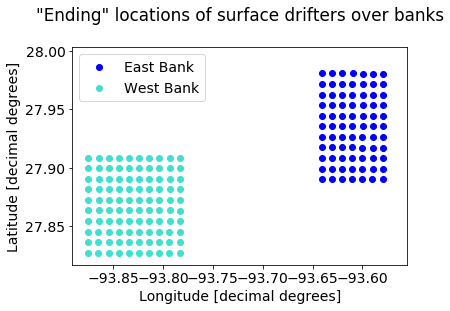

In [155]:
## ending locations of drifters over banks ending 6 July 2010

elonps, elatps, wlonps, wlatps = overbanks(lonps[2010][5],latps[2010][5])

wlon, wlat = tracpy.tools.find_final(wlonps,wlatps)
elon, elat = tracpy.tools.find_final(elonps,elatps)
# plt.scatter(elon,elat)
# plt.scatter(wlon,wlat)

print(elonps.shape)
plt.scatter(elonps[:,0],elatps[:,0],color="blue")
plt.scatter(wlonps[:,0],wlatps[:,0],color="turquoise")

#plt.scatter(grid.lon_rho[0],grid.lat_rho[0])
#plt.scatter(grid.lon_rho[-1],grid.lat_rho[-1])
plt.legend(["East Bank","West Bank"])
plt.title("\"Ending\" locations of surface drifters over banks\n")
plt.xlabel("Longitude [decimal degrees]")
plt.ylabel("Latitude [decimal degrees]")

## 2d tracks

In [8]:
def tracks(lonp,latp,fig,ax,save=False):
    '''plot surface tracks of drifters in every month
    Args:
        lonp[drifter,time]: Drifter longitudes for all times
        latp[drifter,time]: Drifter latitudes for all times
    '''
    
    # Starting marker
    ax.plot(lonp[:, 0], latp[:, 0], 'o', color='g', markersize=3,
            label='_nolegend_', alpha=0.4, transform=pc)

    # Plot tracks
    ax.plot(lonp.T, latp.T, '-', color='grey', linewidth=.2, transform=pc)

    # Find final positions of drifters
    lonpc, latpc = tracpy.tools.find_final(lonp, latp)
    ax.plot(lonpc, latpc, 'o', color='r', label='_nolegend_', transform=pc)

    # Legend, of sorts
    # ax = gca()
    xtext = 0.45
    ytext = 0.18
    ax.text(xtext, ytext, 'starting location', fontsize=16, color='green',
         alpha=.8, transform=ax.transAxes)
    ax.text(xtext, ytext-.03, 'track', fontsize=16, color='grey',
         transform=ax.transAxes)
    ax.text(xtext, ytext-.03*2, 'ending location', fontsize=16, color='red',
         transform=ax.transAxes)

    return fig,ax

/opt/tracpy/tracpy/tools.py:214: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:215: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:210: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:211: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])


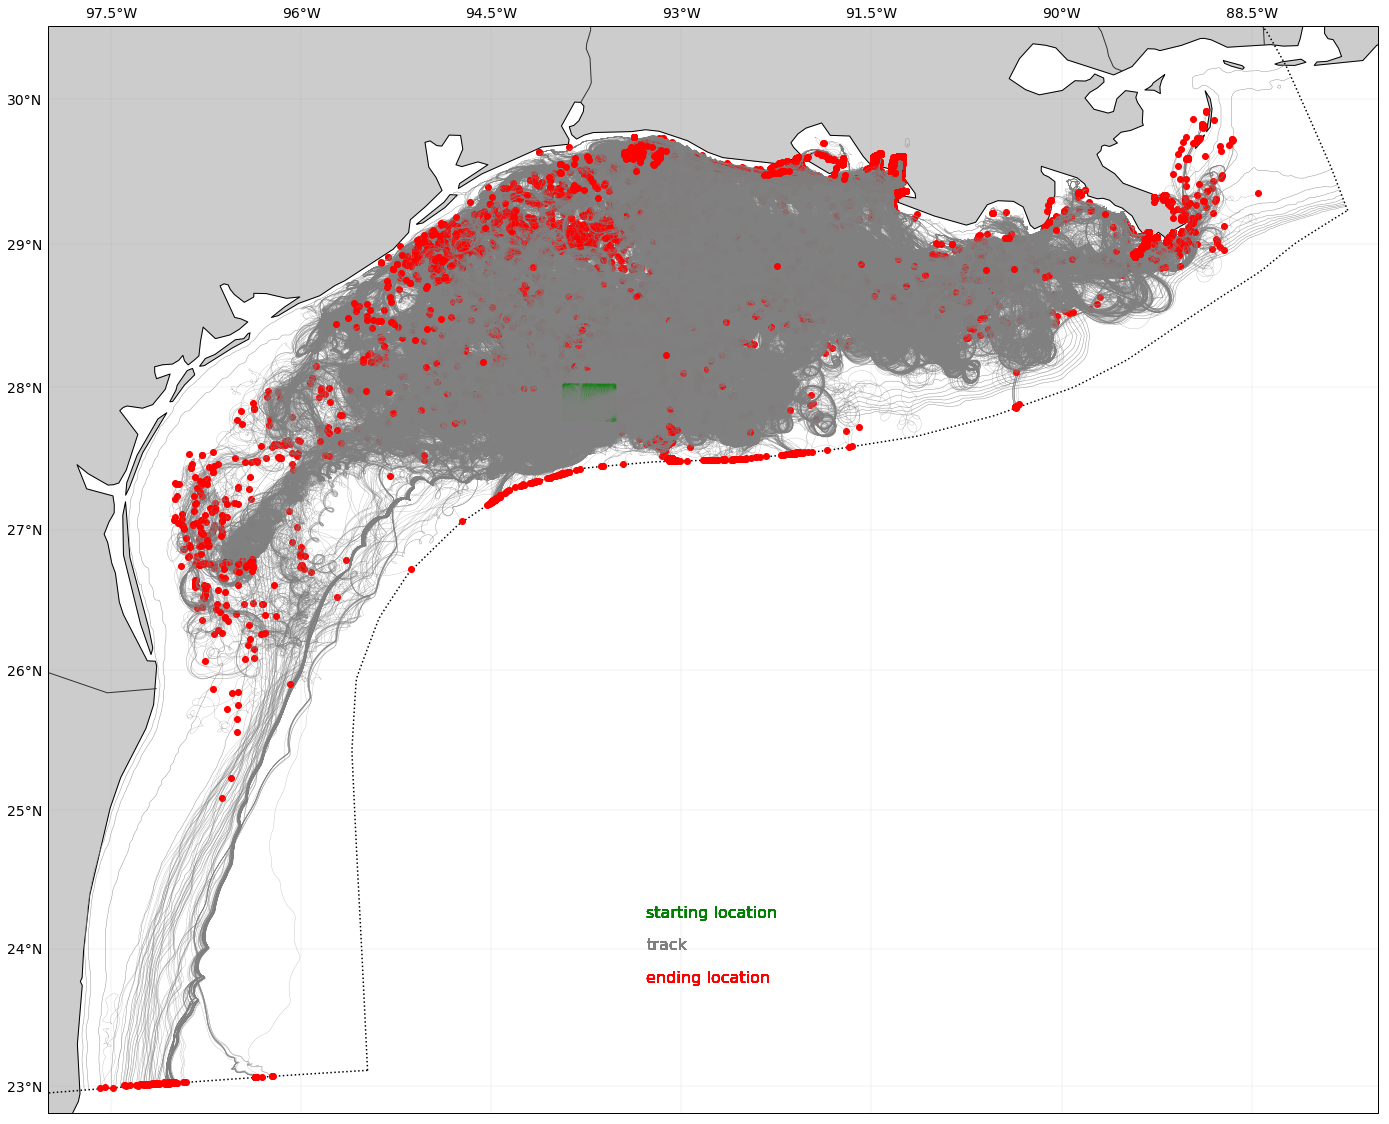

In [9]:
fig = plt.figure(figsize=(30, 20))
fig, ax = tracpy.plotting.background(grid, fig=fig, extent=[-98, -87.5, 22.8, 30.5],
               col='lightgrey', halpha=1, outline=[1, 1, 0, 1], res='50m')

fig, ax = tracks(lonps[2005][0],latps[2005][0],fig,ax)
fig, ax = tracks(lonps[2005][1],latps[2005][1],fig,ax)
fig, ax = tracks(lonps[2005][2],latps[2005][2],fig,ax)
fig, ax = tracks(lonps[2005][3],latps[2005][3],fig,ax)
fig, ax = tracks(lonps[2005][4],latps[2005][4],fig,ax)
fig, ax = tracks(lonps[2005][5],latps[2005][5],fig,ax)
fig, ax = tracks(lonps[2005][6],latps[2005][6],fig,ax)
fig, ax = tracks(lonps[2005][10],latps[2005][10],fig,ax)
fig, ax = tracks(lonps[2005][11],latps[2005][11],fig,ax)
fig, ax = tracks(lonps[2005][12],latps[2005][12],fig,ax)
fig, ax = tracks(lonps[2005][13],latps[2005][13],fig,ax)
fig, ax = tracks(lonps[2005][14],latps[2005][14],fig,ax)
fig, ax = tracks(lonps[2005][15],latps[2005][15],fig,ax)
fig, ax = tracks(lonps[2005][16],latps[2005][16],fig,ax)


## Starting location 2d histogram
- Need to fix axes
- add background map
- check if lognorm is appropriate ✓

In [130]:
def finalhist(lonps, latps, yr, proj, fig, axes,
               bins=(70,60), cmap="BuPu", save=False):
    '''plot drifter starting location concentrations for every day in the month
    Args:
        lonps[year][day][drifter,time]
        latps[year][day][drifter,time]
    '''
    
    lonfs, latfs = finals(lonps,latps)
    for i, ax in enumerate(axes.flat):
#         fig, ax = tracpy.plotting.background(grid, fig=fig, extent=[-98, -87.5, 22.8, 30.5],
#                col='lightgrey', halpha=1, outline=[1, 1, 0, 1], res='50m')
#         xp,yp = proj(lonps[1994+i][0], latps[1994+i][0])
#         xp = np.array(xp)
#         yp = np.array(yp)
#         tracpy.plotting.hist(xp, yp, proj, "test_2d", grid, tind="final", which='hist2d')



        year = 1994 + i
        if year > yr: break  # don't have data beyond yr
        print(year)
        fig, ax = tracpy.plotting.background(grid, fig=fig, extent=[-98, -87.5, 22.8, 30.5],
               col='lightgrey', halpha=1, outline=[1, 1, 0, 1], res='50m')    # ,range=[[-422893.1840546361, 607114.2511548102],[-773600.0225372436, 105158.33625709431]]
        lons,lats = [],[]
        for day in range(31):
            lons += lonfs[year][day]
            lats += latfs[year][day]
        
        x,y = proj(lons,lats)
        ax.hist2d(x, y, bins=bins, norm=colors.LogNorm(),cmap=cmap)
        ax.set_title("July %d" %(year),size=36)

#         cbcoords = [0.35, 0.25, 0.6, 0.02]
#         cax = fig.add_axes(cbcoords)  # colorbar axes
#         pos = ax.imshow(x, cmap=cmap, interpolation='none')
#         cb = fig.colorbar(pos,cax=cax, orientation='horizontal')
#         cb.set_label('Final drifter location (percent)')

    return fig, axes


/opt/tracpy/tracpy/tools.py:214: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:215: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:210: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:211: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])


1994


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


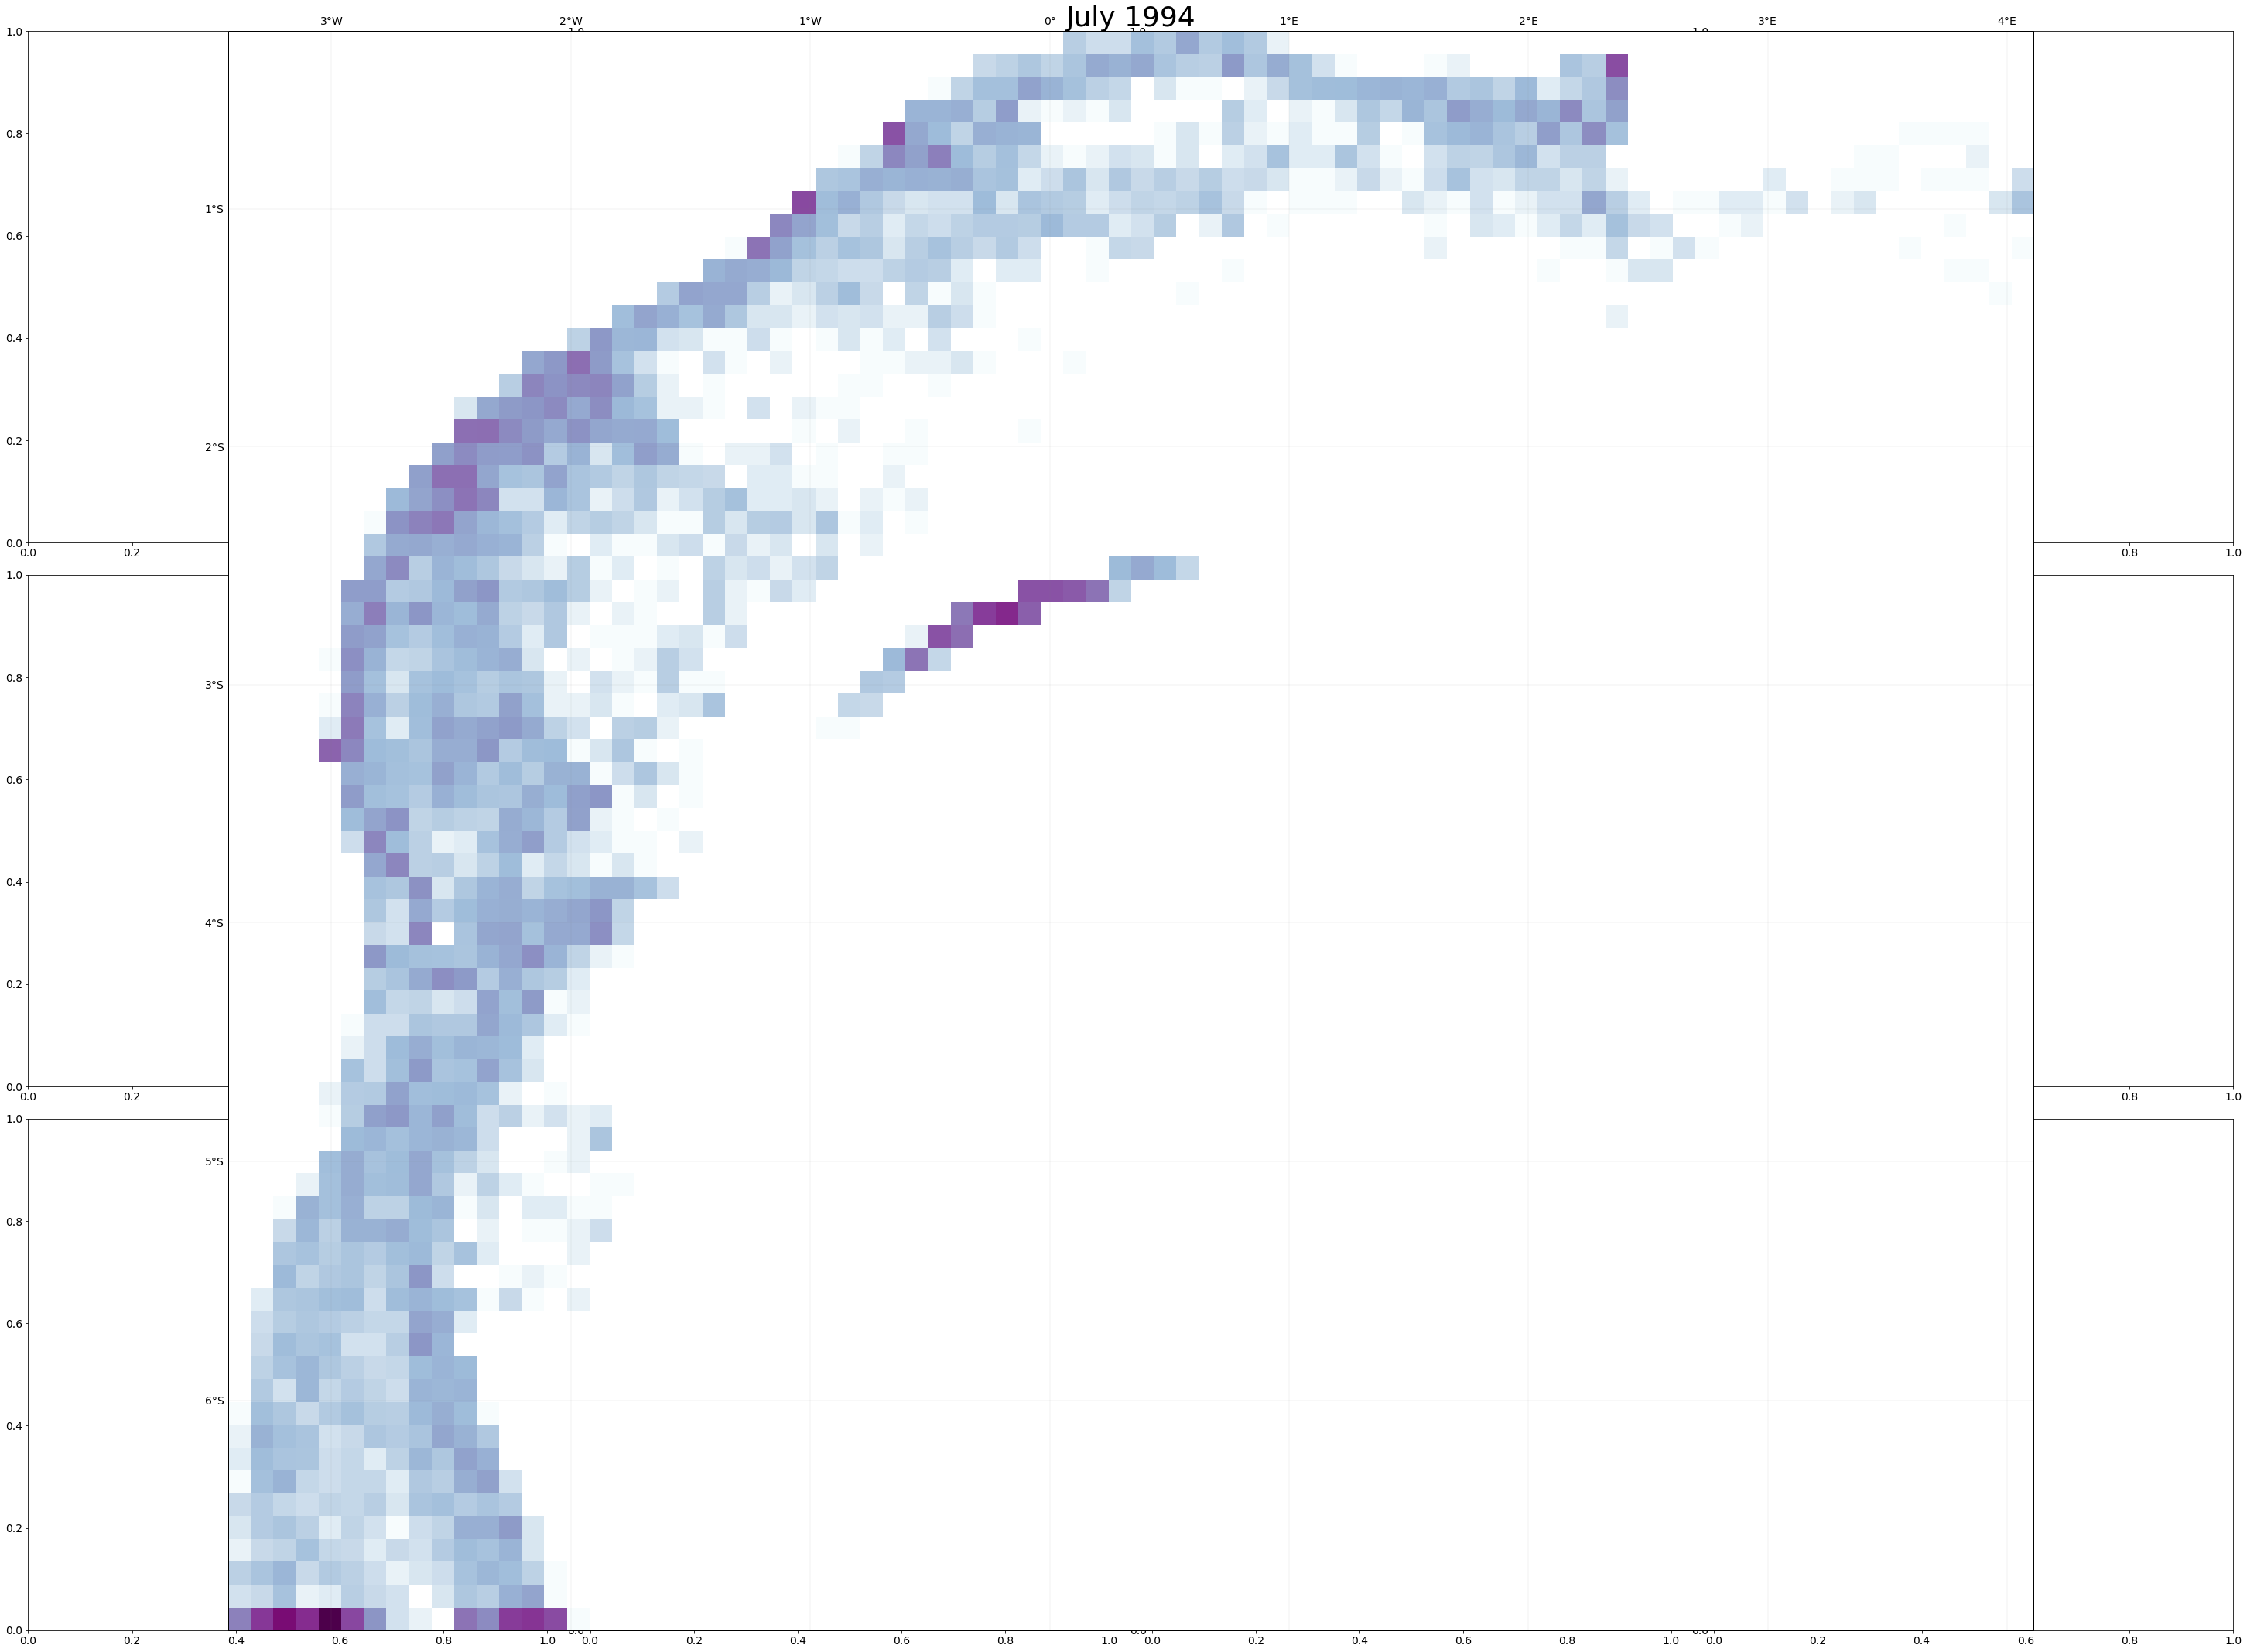

In [133]:
fig, axes = plt.subplots(3, 4, figsize=(40, 30), tight_layout=True)
fig, axes = finalhist(lonps,latps,1994,proj,fig=fig,axes=axes,bins=(80,70))


## Surface temperature trends

In [4]:
def temp(lonp,latp):
    '''return surface temperature from ROMS
    ***temperature from water column***
    
    Args:
        lonp: [drifter,time] Ending drifter longitudes
        latp: [drifter] Ending drifter latitudes
    '''
    
    return fig, ax



## Surface salinity trends

In [ ]:
def salinity(lonp,latp):
    '''return surface salinity from ROMS
    ***salinity from water column***'''
    
    return fig, ax


/opt/tracpy/tracpy/tools.py:216: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:217: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:212: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  xpc.append(xp[idrift, find(ind3)[ind]])
/opt/tracpy/tracpy/tools.py:213: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  ypc.append(yp[idrift, find(ind3)[ind]])
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using t

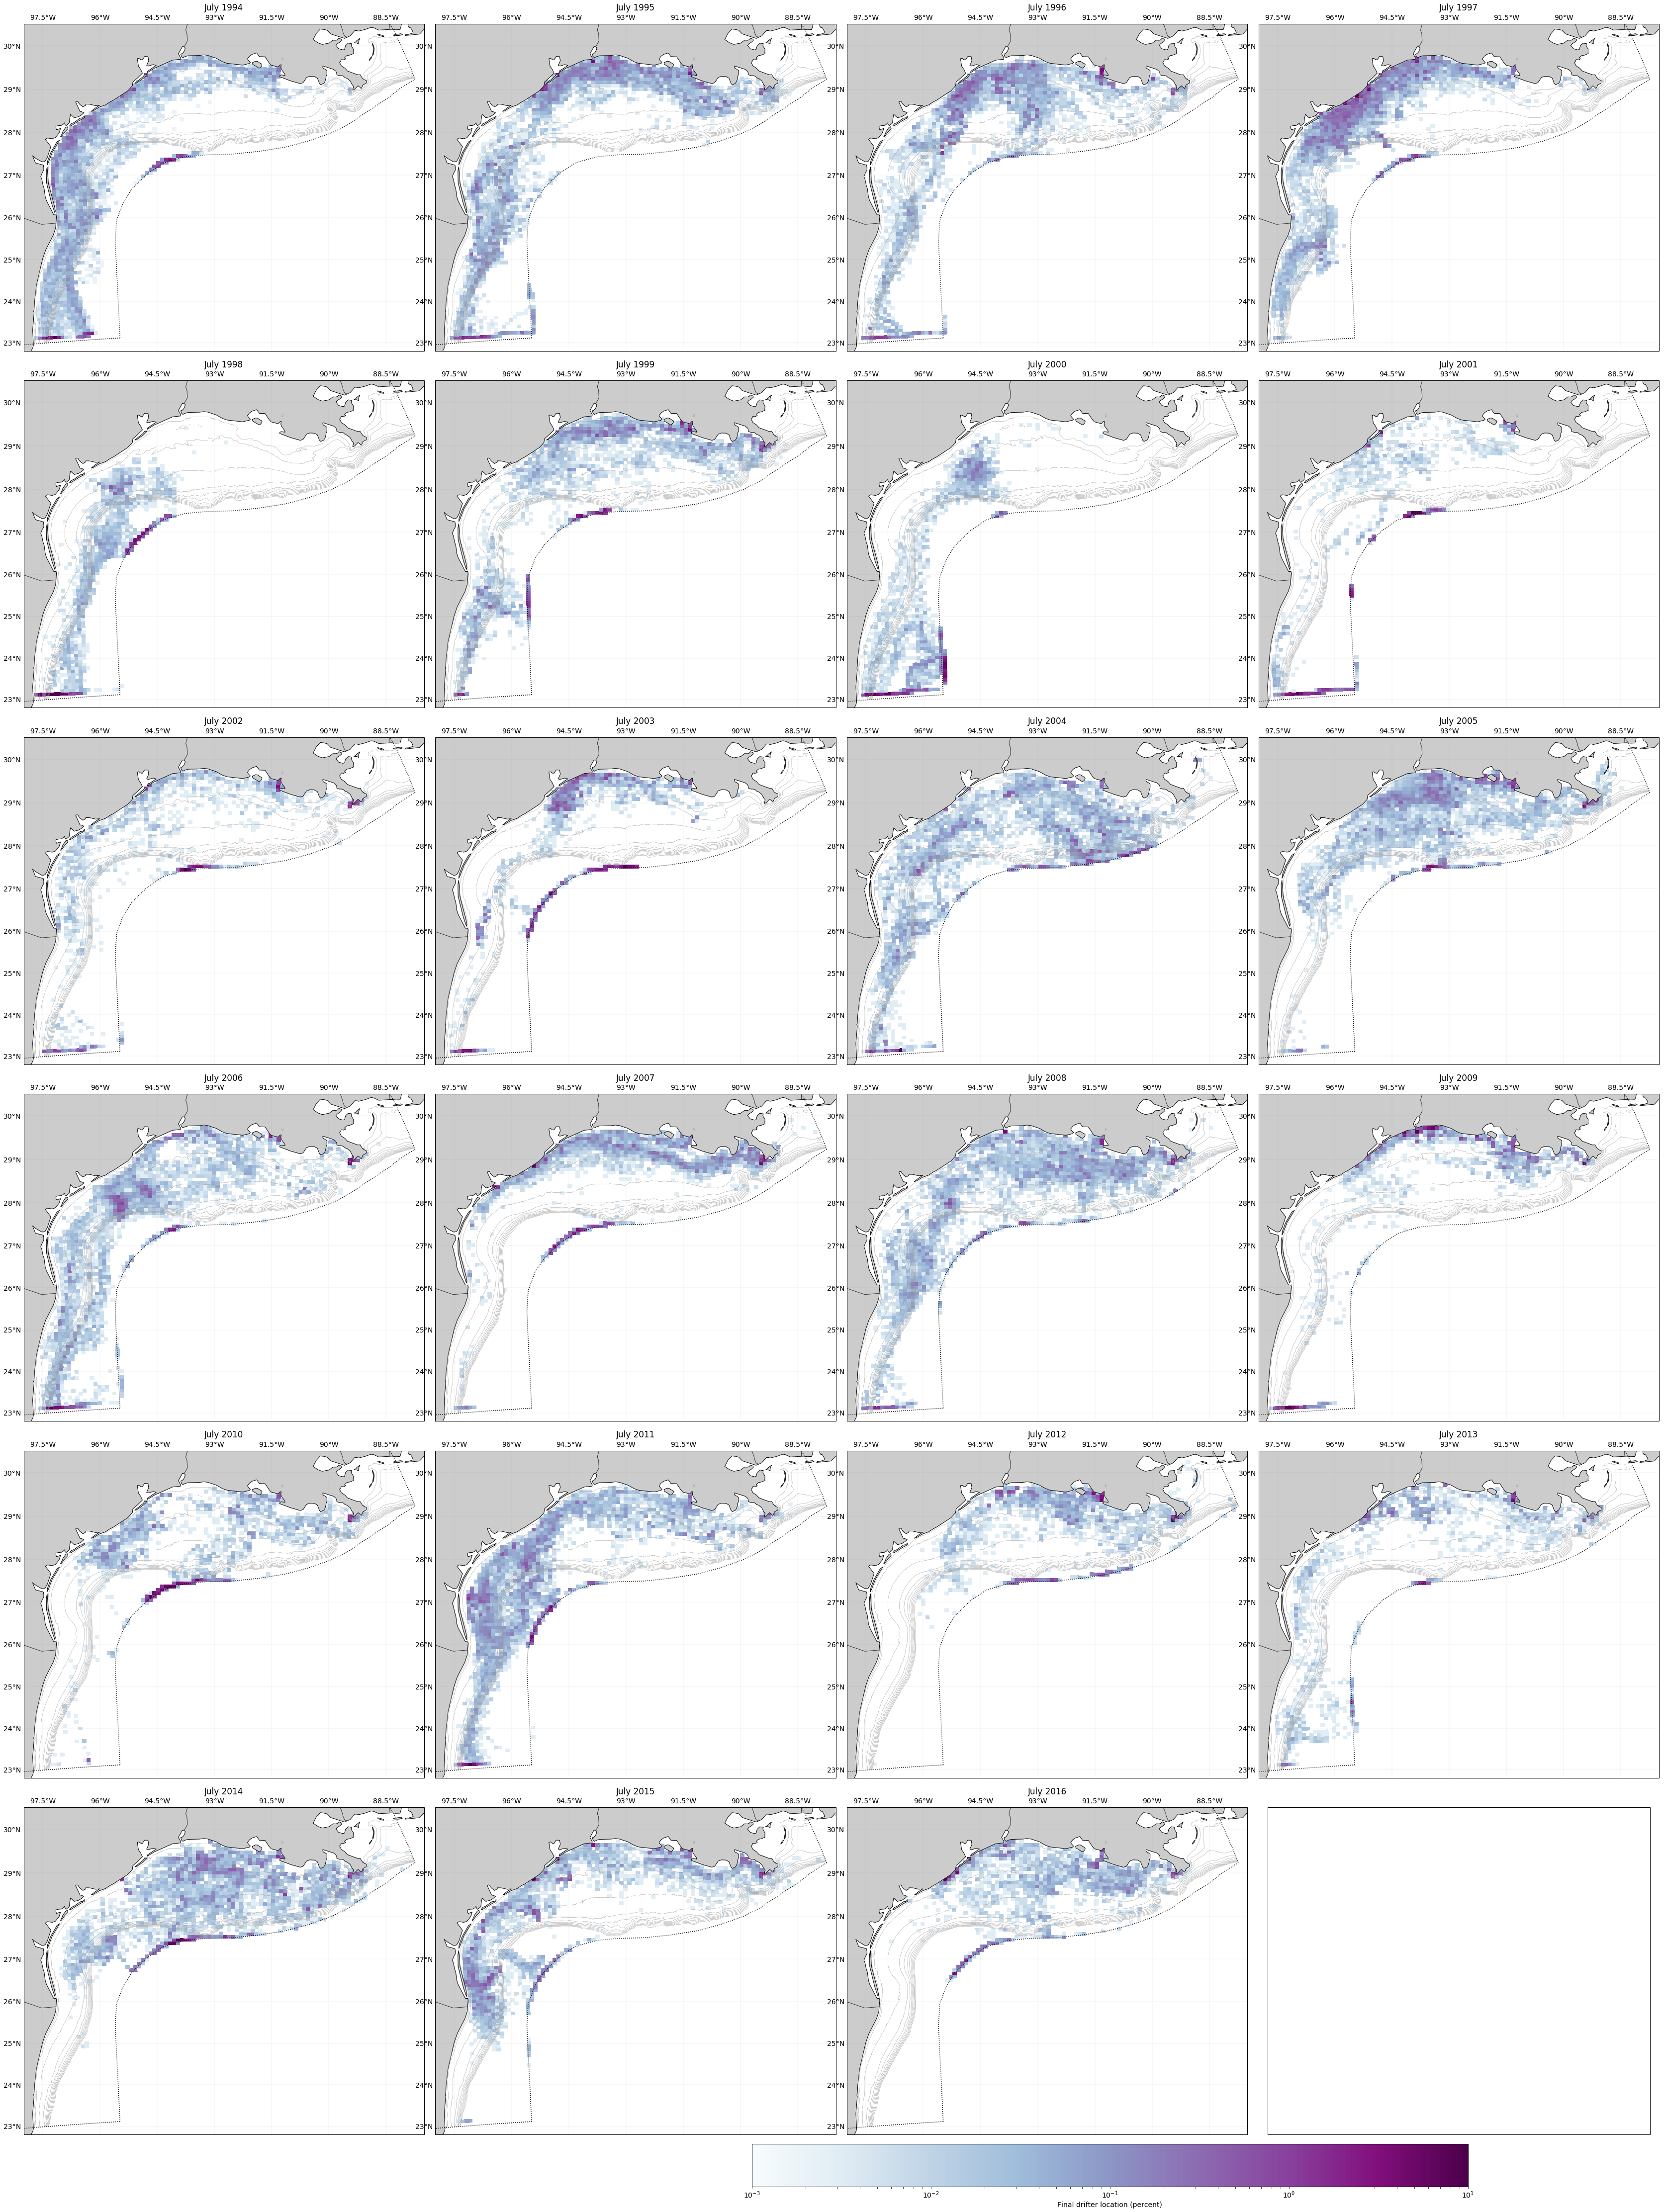

In [41]:
import cmocean.cm as cmo
lonfs, latfs = finals(lonps,latps)
fig, axes = plt.subplots(6, 4, figsize=(50, 60), tight_layout=True, subplot_kw=dict(projection=cartopy.crs.Mercator()))
yr = 2016
for i, ax in enumerate(axes.flat):
    year = 1994 + i
    if year > yr: break
        
    lons,lats = [],[]
    for day in range(31):
        lons += lonfs[year][day]
        lats += latfs[year][day]
            
    tracpy.plotting.background(grid, ax=ax, fig=fig, extent=[-98, -87.5, 22.8, 30.5],
                               col='lightgrey', halpha=1, outline=[1, 1, 0, 1], res='50m')    # ,range=[[-422893.1840546361, 607114.2511548102],[-773600.0225372436, 105158.33625709431]]

    x,y = proj(lons,lats)
    tracpy.plotting.hist(np.asarray(x), np.asarray(y), proj, "test", grid, tind='all', which='pcolor',
                             cmap="BuPu", cbcoords=[0.45, -0.02, 0.4, 0.02],
                             fig=fig, ax=ax, bins=(100, 100), N=100, xlims=None,
                             ylims=None, C=None, Title="July %d\n" %year, weights=None,
                             Label='Drifter locations (%)', binscale=None, logscale=True, vmax=10,
                             crsproj=cartopy.crs.LambertConformal(central_latitude= 30, central_longitude=-94))
